In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from tqdm import tqdm
import string

import LMRt

## Load data

In [2]:
exp_dict = {
    'LMR (Corals)': '../recons/recon_Corals.nc',
    'LMR (Li13b6)': '../recons/recon_Li13b6.nc',
    'LMR (Corals+Li13b6)': '../recons/recon_Corals_Li13b6.nc',
}

In [3]:
nino34 = {}
year = {}
for exp_tag, path in exp_dict.items():
    with xr.open_dataset(path) as ds:
        nino34[exp_tag] = ds['nino34'].values
        year[exp_tag] = ds['year'].values

In [4]:
for exp_tag, path in exp_dict.items():
    yr_min = np.min(year[exp_tag])
    yr_max = np.max(year[exp_tag])
    print(exp_tag, ':', yr_min, yr_max)

LMR (Corals) : 1100 2000
LMR (Li13b6) : 1100 2000
LMR (Corals+Li13b6) : 1100 2000


In [5]:
# SI Table 3 of Toohey et al. (2019): https://doi.org/10.1038/s41561-018-0286-2 + eVolv2k v3 (VSSI>6)
vssi = {
    1107: 19.16,
    1170: 18.05,
    1182: 10.05,
    1191: 8.53,
    1229: 23.78,
    1257: 59.42,
    1275: 11.53,
    1286: 15.06,
    1343: 15.11,
    1452: 9.97,
    1458: 32.98,
    1586: 8.51,
    1594: 8.87,
    1600: 18.95,
    1640: 18.68,
    1695: 15.74,
    1783: 20.81,
    1809: 19.26,
    1815: 28.08,
    1835: 9.48,
    1883: 9.34,
    1991: 8.50,
}

# load Palmyra
df_palmyra = pd.read_table('../data/palmyra2013.txt', skiprows=118)
corals_available_yrs = sorted(list(set([int(t) for t in df_palmyra['age'].values])))

eruption_yrs = sorted(list(vssi.keys()))
print(len(eruption_yrs), eruption_yrs)

22 [1107, 1170, 1182, 1191, 1229, 1257, 1275, 1286, 1343, 1452, 1458, 1586, 1594, 1600, 1640, 1695, 1783, 1809, 1815, 1835, 1883, 1991]


## Visualization

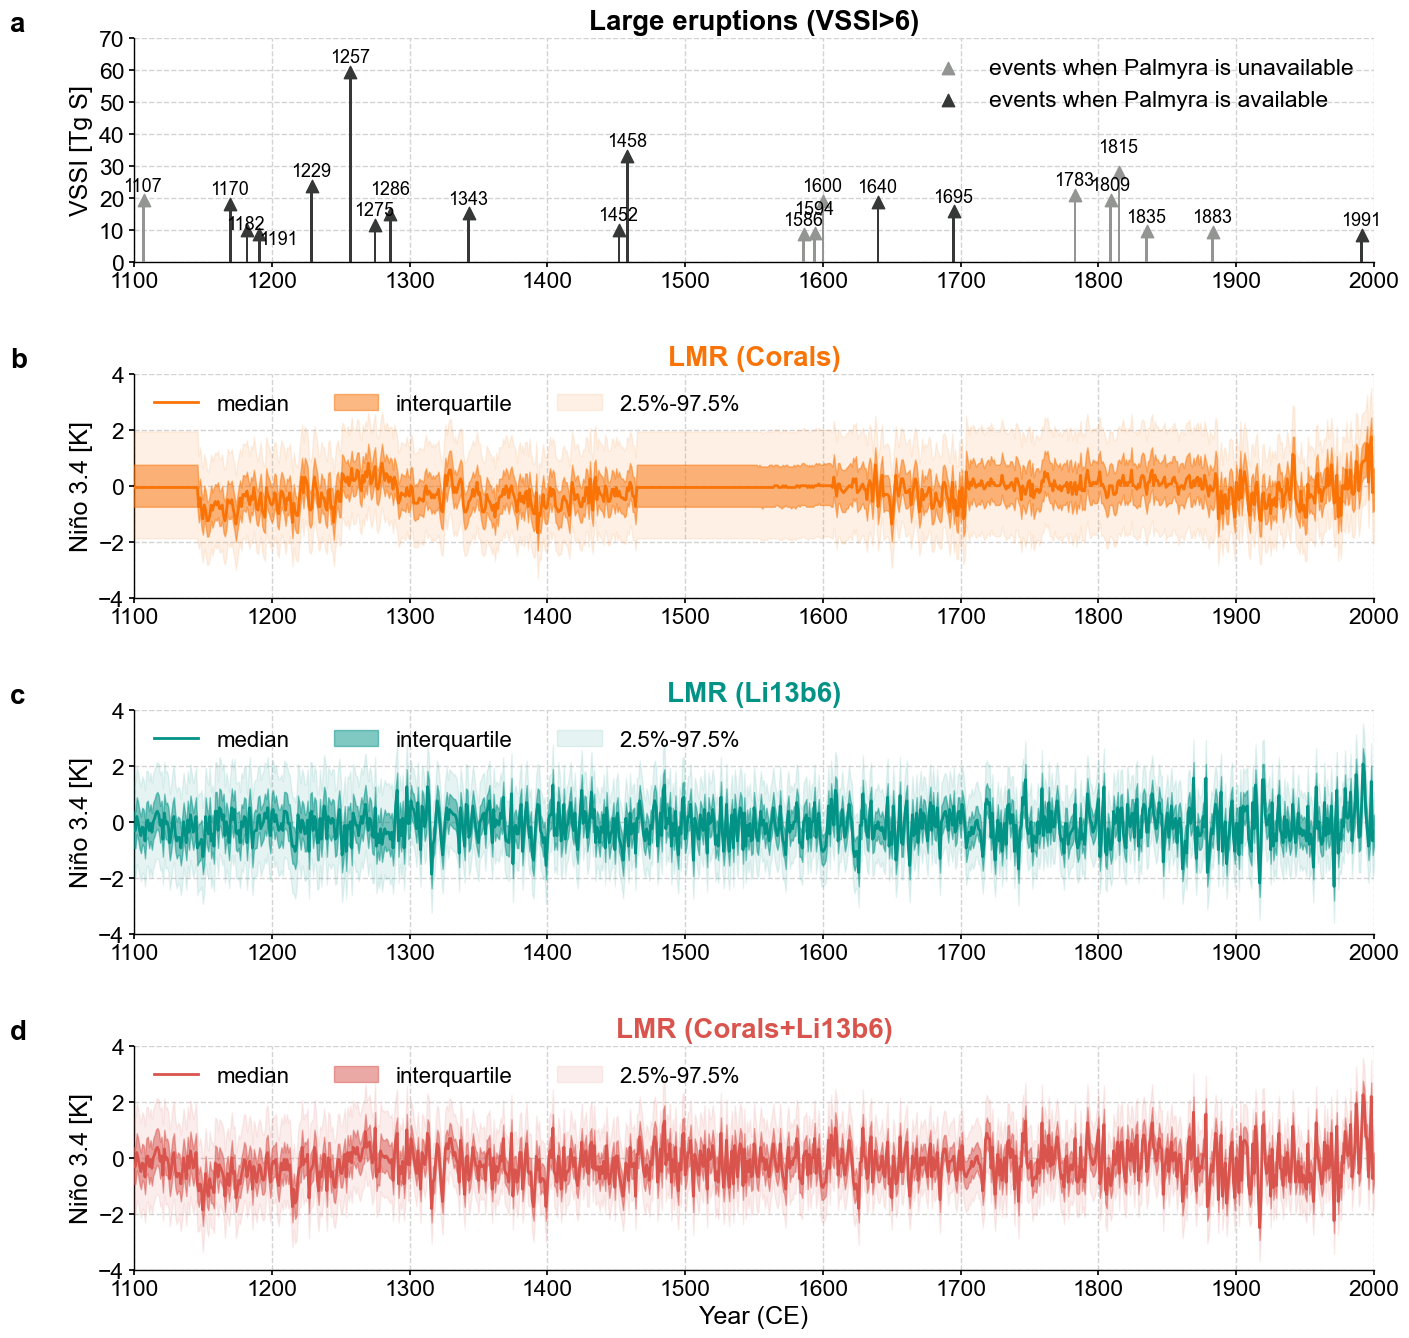

Figure saved at: "../figs/Fig-2.pdf"


In [6]:
LMRt.set_style('journal', font_scale=1.5)

exp_color = {
    'LMR (Corals)': sns.xkcd_rgb['orange'],
    'LMR (Li13b6)': sns.xkcd_rgb['teal'],
    'LMR (Corals+Li13b6)': sns.xkcd_rgb['pale red'],
}


fig = plt.figure(figsize=[16, 16])
gs = gridspec.GridSpec(4, 1)       
gs.update(wspace=0.2, hspace=0.5)

ax = {}

ax['events'] = plt.subplot(gs[0])
ax['events'].set_ylabel('VSSI [Tg S]')
ax['events'].set_title('Large eruptions (VSSI>6)', fontweight='bold', fontsize=20)
ax['events'].set_ylim(0, 70)
ax['events'].set_yticks(np.arange(0, 71, 10))
ax['events'].set_xlim([1100, 2000])

first_selected = True
first_ignored = True
last_e = 1100
last_v = 1
up_shift = 1
for e, v in vssi.items():
        
    if e in corals_available_yrs:
        clr = sns.xkcd_rgb['dark grey']
        legend_label = 'events when Palmyra is available' if first_selected else None
        first_selected = False
    else:
        clr = sns.xkcd_rgb['grey']
        legend_label = 'events when Palmyra is unavailable' if first_ignored else None
        first_ignored = False
        
    clr_yr = sns.xkcd_rgb['black']
        
    if e - last_e < 20 and np.abs(v-last_v) < 10:
        if v>=last_v:
            up_shift += 1
        elif v<last_v:
            up_shift -= 1
    else:
        up_shift = 1
        
    if e == 1191:
        ax['events'].text(e, v+3*up_shift, e, color=sns.xkcd_rgb['black'], fontsize=13, zorder=99)
    else:
        ax['events'].text(e-15, v+3*up_shift, e, color=sns.xkcd_rgb['black'], fontsize=13, zorder=99)
    ax['events'].bar(e, v, color=clr, zorder=97, width=2)
    ax['events'].scatter(e, v, marker='^', s=80, color=clr, label=legend_label, zorder=98)
    
    last_e = np.copy(e)
    last_v = np.copy(v)
    
ax['events'].legend(loc='upper right')
    
syr, eyr = 1100, 2000
for i, exp_tag in enumerate(exp_color.keys()):
    mask = (year[exp_tag]>=syr) & (year[exp_tag]<=eyr)
    
    # plot
    ax[exp_tag] = plt.subplot(gs[i+1], sharex=ax['events'])
    ax[exp_tag].plot(year[exp_tag][mask], nino34[exp_tag][2, mask], color=exp_color[exp_tag], zorder=98, label='median')
    ax[exp_tag].fill_between(
        year[exp_tag][mask], nino34[exp_tag][1, mask], nino34[exp_tag][-2, mask],
        color=exp_color[exp_tag], alpha=0.5, zorder=97, label='interquartile',
    )
    ax[exp_tag].fill_between(
        year[exp_tag][mask], nino34[exp_tag][0, mask], nino34[exp_tag][-1, mask],
        color=exp_color[exp_tag], alpha=0.1, zorder=96, label='2.5%-97.5%',
    )
    
    ax[exp_tag].set_title(exp_tag, color=exp_color[exp_tag], fontweight='bold', fontsize=20)
    ax[exp_tag].set_ylabel('Niño 3.4 [K]')
    ax[exp_tag].set_ylim([-4, 4])
    
ax[exp_tag].set_xlabel('Year (CE)')

# legend
for k in exp_dict.keys():
    ax[k].legend(
        frameon=False,
        loc='upper left',
        fontsize=16,
        ncol=3,
    )

    
#====================================================
fs = 20
for i, tag in enumerate(ax.keys()):
    ax[tag].text(
        -0.1, 1.03, string.ascii_lowercase[i],
        transform=ax[tag].transAxes, 
        size=fs, weight='bold',
    )
    
LMRt.showfig(fig)
LMRt.savefig(fig, '../figs/Fig-2.pdf')